# Time Series Analysis and Fourier Methods


## Geoinfo Tutorial Outline

1. ...done ...
2. Computing the PSD (or amplitude spectrum)
3. Good Practices to dealing with Fourier transforms
4. Cross-correlation
5. Deconvolution

### Instructor: Germán A. Prieto (gaprietogo@unal.edu.co)

Import basic packages that we will use. 

In [3]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt
import obspy
import time
from obspy.clients.fdsn import Client

## Example 1. A synthetic example

The toy signal has a fundamental frequency (that WE NEED to determine), inmersed in a background colored-spectra.
The toy signal really has 10 *realizations*, in the code below one of the *realizations* is randomly selected.

### Compute the spectrum

To estimate the PSD, we need to follow the following equation:
$$ Y(f) = \sum_{n=0}^{N-1} x_n a_n e^{-2\pi i f t} $$
where $a_n$ is a windowing function or taper. 

The PSD estimate of the true spetrum $S(f)$ is then estimated via
$$ \hat{S}(f) = {| Y(f) |}^2 $$

**To avoid complications in explaining the codes, I normalize the spectrum in a quick way (could be better). One should always do it**

$$ var(x) = \int_{-1/2}^{1/2} S(f) df = \sum_{n=0}^{nfft} S(f) * df$$

You should have access to the data ``test1.dat`` thru Slack.

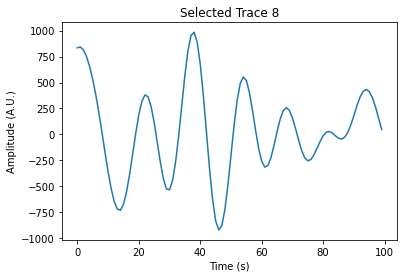

In [3]:
x       = np.loadtxt('test1.dat')
npts    = np.size(x,0)
ntr     = np.size(x,1)
dt      = 1.0  # 1 sps
t       = np.arange(0,npts)*dt

# randomly select one trace
itr     = np.random.randint(0,ntr)
x2      = x[:,itr]
xvar    = np.var(x2)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t,x2)
ax.set_title('Selected Trace '+str(itr));
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (A.U.)');


**Calculate Periodogram (with box car taper)**

You should never really do this, but just so you know, this is how we would do it. 

In [17]:
# Check if data is even or odd, define nf
   
if (npts%2==0):
    nf = round(npts/2.)   #nf es el punto de corte deond ela señal se vuelve a repetir
    
else:
    nf = round((npts+1)/2)
# Get frequency vector

freq = scipy.fft.fftfreq(npts,dt)
freq = abs(freq[0:nf])
df = freq[1]

# calculate Periodogram (***** bad idea, never do *****)

Sp = scipy.fft.fft(x2,npts)
Sp = abs(Sp)**2
Ssc = xvar/(np.sum(Sp)*df)
Sp = Sp*Ssc
Sp = 2*Sp[0:nf]

# plot results

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq.Sp)
ax.semilogy(freq,Sp)
ax.set_title('Trace = '+str(itr))


**Calculate tapered periodogram (with a hanning taper, or other)**

In this case I will use a Hanning taper, but you could easily apply other tapers, including
the prolate tapers (used in the multitaper algorithm). 
for example ``dpss,v = signal.windows.dpss(nwin, tbp, Kmax=kspec, return_ratios=True)``

In [18]:
# Calculate hanning periodogram
hann = np.hanning(npts)   #ventana hanning, se hace para quitar el efecto
xhan = x2*hann            #leackage, se tiene que eliminar este efecto

Sh = scipy.fft.fft(x2,npts)
Sh = abs(Sh)**2
Ssc = xvar/(np.sum(Sh)*df)
Sh = Sh*Ssc
Sh = 2*Sh[0:nf]


# Plot results on same plot to compare

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq.Sp)
ax.semilogy(freq,Sp)
ax.semilogy(freq,Sh)
ax.set_title('Trace = '+str(itr))


## Notes

Here it is clear why _spectral leakage_ is a real problem. You need to avoid using the raw periodogram. 

**Good Practice**
- Detrend the signal (or at least demean the signal).
- Always use a taper.
- Zero padding is a good idea. But pad after tapering, not before. 
- Always (done roughly here) normalize your power spectrum, to get the right units. The integral of the PSD is equal to the variance of the time series.  
- Amplitude spectrum = $\sqrt{S(f)*T}$, where $T$ is the length of the time series in seconds. 
- Spectra units 
    - PSD - $units^2/Hz$
    - Amplitude spectrum $units/Hz=units.s$. 


## Example 2. Sunspot counts since 1750


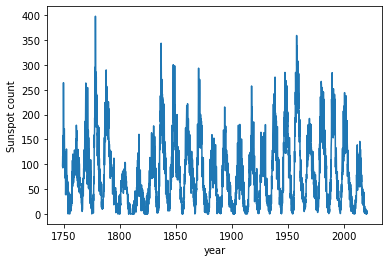

In [6]:
data = np.loadtxt('sunspot_monthly.txt')

t      = data[:,2]
sp_cnt = data[:,3]
dt     = 1.0/12.0   # in years
npts   = np.size(sp_cnt)

#-------------------------------------------
# Calculate variance
#-------------------------------------------

spvar = np.var(sp_cnt)

#-------------------------------------------
# Plot time series
#-------------------------------------------

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t,sp_cnt);
ax.set_xlabel('year');
ax.set_ylabel('Sunspot count');


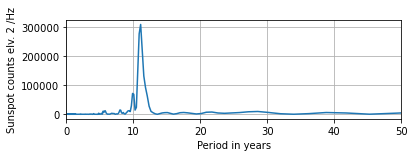

In [22]:
# Remove mean

sp =signal.detrend(sp_cnt,type="constant")
#-------------------------------------------
# Calculate spectrum
#-------------------------------------------


npts2 = npts*2
freq = scipy.fft.rfftfreq(npts2,dt)  #rfftfreq solo usa frecuencias positivas (r al inicio)
df = freq[1]  #df es tasa de meustreo en frecuencia

# Calculate hanning periodogram, with zero padding

hann = np.hanning(npts)  #Ventanas son utiles apra aligerar datos y resaltar otras cosas
dwin = np.zeros(npts2) #Señal de ceros con eld oble de la longitud
dwin[0:npts] = sp*hann   #Se pega la señal

Ph = scipy.fft.rfft(dwin,npts2)

#-------------------------------------------
# Normalize PSD to variance of data
#-------------------------------------------

Ph = 2.0*abs(Ph)**2
Psc = spvar / (np.sum(Ph)*df)    # conrmalizaciòn con base en el escalador
Ph = Ph*Psc                        #valores pequeños

# Plot results and interpret

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(1/freq[1::],Ph[1::])
ax.set_ylabel("Sunspot counts elv. 2 /Hz")
ax.set_xlabel("Period in years")
ax.set_xlim((0, 50))
ax.grid()

#ax1 = fig.add_subplot(212)
#ax1.plot(1/freq[1::],Ph[1::])
#ax1.set_ylabel("Sunspot counts elv. 2 /Hz")
#ax1.set_xlabel("Period in years")
#ax1.set_xlim((8, 15)



## Example 3. Seismology example - Normal modes for Sumatra Earthquake

The Sumantran earthquake of December 2004, excited many of the normal modes of the Earth. The modes of our planet are in the order of $m$Hz, with examples 
- $_0S_0$, having a frequency 0.81 $m$Hz, period of about 20 min.
- $_0S_4$, having a frequency 0.62 $m$Hz, period of about 26 min.
- $_0S_3$, having a frequency 0.45 $m$Hz, period of about 37 min.

You should have access to the data ``sumatra.mseed`` thru Slack, but if not, just remove comments to download the data. 

1 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2004-12-26T00:00:00.485600Z - 2004-12-29T23:59:59.485600Z | 1.0 Hz, 345600 samples


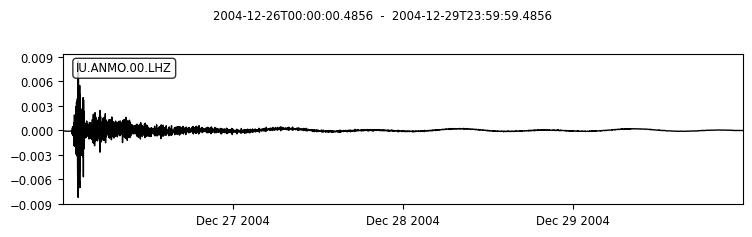

In [23]:
#SDownload data from IRIS (only if you need to)
#client = Client("IRIS")
#t1 = obspy.UTCDateTime("2004-12-26")
#starttime = t1
#endtime = t1 + 4*24*60*60  # 4 days of data
#net = "IU"
#sta = "ANMO"
#loc = "00"
#chan = "LHZ"
#st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st.remove_response(output = 'DISP')
#st = st.write("sumatra.mseed", format="MSEED")  

st = obspy.read('sumatra.mseed')

print(st)
st.plot()


## Note

We will try to do all our calculations ourselves, not with the default from Obspy. Pull out the data and info needed.

**Here we will pad with zeros to double the length of the signal**. This does not improve the resolution of the FFT, but avoids the cycling issue of the FFT. This is especially important for correlations, deconvolution, etc. 

In [9]:
tr    = st[0]
data  = tr.data
dt    = tr.stats.delta
npts  = tr.stats.npts
npts2 = 2*npts
nf    = int(npts2/2 + 1)

print(npts, npts2, nf)

345600 691200 345601


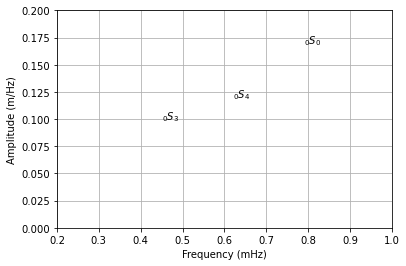

In [23]:
x3    = signal.detrend(data,type='constant')
xvar3 = np.var(x3)
Tall  = dt*npts2   # the length of the series

# Calculate hanning periodogram, calculate amplitude spectrum




fig = plt.figure()
ax = fig.add_subplot(111)
# add data to plot here

ax.set_xlim(0.2 , 1)
ax.set_ylim(0, 0.20)
ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Amplitude (m/Hz)')
ax.text(0.79, 0.17, '$_0S_0$')
ax.text(0.62, 0.12, '$_0S_4$')
ax.text(0.45, 0.10, '$_0S_3$')
ax.grid()